In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [13]:
data_directory="/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/"

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)

test_datagen = ImageDataGenerator(rescale=1./255)  

valid_datagen = ImageDataGenerator(rescale=1./255)  


target_size = (224, 224)  

batch_size = 32  

train_generator = train_datagen.flow_from_directory(
    directory=data_directory + "train/",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

test_generator = test_datagen.flow_from_directory(
    directory=data_directory + "test/",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=data_directory + "valid/",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


Found 1480 images belonging to 296 classes.
Found 1480 images belonging to 296 classes.
Found 1480 images belonging to 296 classes.


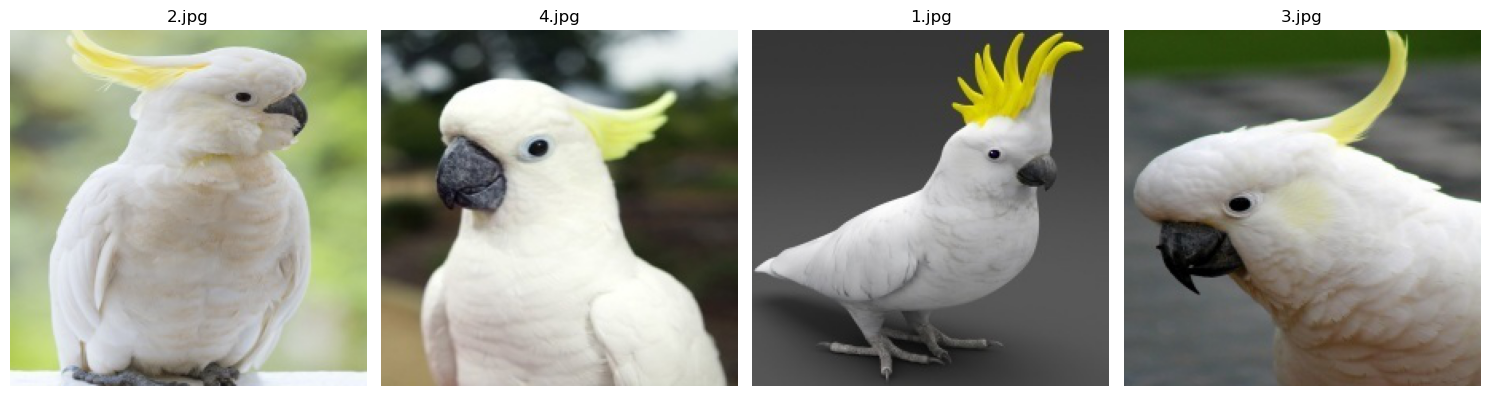

In [8]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_random_images_for_bird(bird_species, num_images_to_display=4):
    
    data_directory = "/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/train/"

    bird_directory = os.path.join(data_directory, bird_species)

    image_files = [f for f in os.listdir(bird_directory) if os.path.isfile(os.path.join(bird_directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    num_images_to_display = min(num_images_to_display, len(image_files))
    random_image_files = random.sample(image_files, num_images_to_display)
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

    for i, image_file in enumerate(random_image_files):
        
        image_path = os.path.join(bird_directory, image_file)
        image = mpimg.imread(image_path)

       
        axes[i].imshow(image)
        axes[i].axis('off')  

        axes[i].set_title(image_file)

    plt.tight_layout()
    plt.show()

display_random_images_for_bird("COCKATOO", num_images_to_display=4)


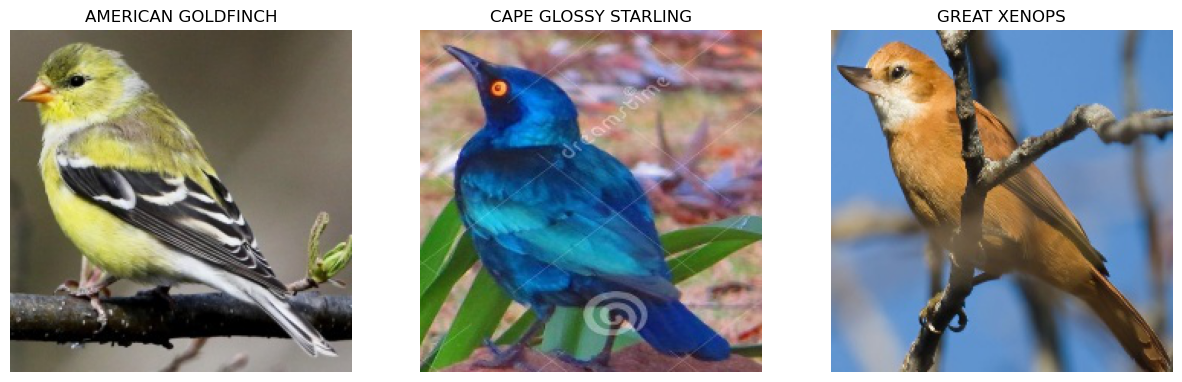

In [9]:
def view_random_image(data_directory, bird_species):
    bird_directory = os.path.join(data_directory, bird_species)
    image_files = [f for f in os.listdir(bird_directory) if os.path.isfile(os.path.join(bird_directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(bird_directory, random_image_file)
    return mpimg.imread(random_image_path)

def display_random_images(data_directory, bird_species_list):
    num_species = len(bird_species_list)
    plt.figure(figsize=(15, 7))
    for i, bird_species in enumerate(bird_species_list, start=1):
        plt.subplot(1, num_species, i)
        plt.imshow(view_random_image(data_directory, bird_species))
        plt.title(bird_species)
        plt.axis('off')
    plt.show()

# Example usage
data_directory = "/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/train"
bird_species_list = ["AMERICAN GOLDFINCH", "CAPE GLOSSY STARLING", "GREAT XENOPS"]
display_random_images(data_directory, bird_species_list)


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Lambda

# Custom Global Average Pooling layer
class GlobalAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GlobalAveragePooling2D, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=[1, 2])

    def get_config(self):
        config = super(GlobalAveragePooling2D, self).get_config()
        return config

# Function to create CNN model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Function to create RNN model
def create_rnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(128)(inputs)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Function to create LBP model
def create_lbp_model(input_shape, num_classes):
    def lbp_layer(img):
        def lbp_func(image):
            def lbp_calc(image):
                # Compute Local Binary Patterns (LBP)
                lbp_image = np.random.rand(*image.shape)  # Placeholder for LBP computation
                return lbp_image

            lbp_image = tf.map_fn(lbp_calc, img)
            return lbp_image

        return tf.map_fn(lbp_func, img)

    inputs = Input(shape=input_shape)
    x = Lambda(lbp_layer)(inputs)
    x = GlobalAveragePooling2D()(x)  # Custom Global Average Pooling layer
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 10  # Adjust this according to the number of bird species classes

# Create CNN model
cnn_model = create_cnn_model(input_shape, num_classes)

# Create RNN model
rnn_model = create_rnn_model((None, input_shape[0]), num_classes)

# Create LBP model
lbp_model = create_lbp_model(input_shape, num_classes)

# Print model summaries
print("CNN Model Summary:")
cnn_model.summary()

print("\nRNN Model Summary:")
rnn_model.summary()

print("\nLBP Model Summary:")
lbp_model.summary()


CNN Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56

In [7]:
# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the LBP model
lbp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the directories for the training, validation, and test sets
# train_dir = '/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/train'
# validation_dir = '/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/valid'
# test_dir = '/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/test'

# # Define data generators for training, validation, and test sets
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# # Define the batch size
# batch_size = 32

# # Generate batches of training, validation, and test data
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),  # Resize images to 224x224
#     batch_size=batch_size,
#     class_mode='categorical'  # Use categorical labels
# )

# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # Optionally, you can also retrieve class labels and indices
# class_labels = train_generator.class_indices
# class_indices = {v: k for k, v in class_labels.items()}

# # Now, you can use these data generators to train your model
# # and evaluate its performance on the validation and test sets
# # Assuming you have updated the num_classes variable with the correct number of classes
# num_classes = 525  # Update this with the correct number of classes in your dataset

# # Update the output layer of your model to reflect the correct number of classes
# output_layer = Dense(num_classes, activation='softmax')




# # Train the CNN model
# cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)

# # Train the RNN model
# rnn_model.fit(train_generator_rnn, epochs=10, validation_data=validation_generator_rnn)

# # Train the LBP model
# lbp_model.fit(train_generator_lbp, epochs=10, validation_data=validation_generator_lbp)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directories for the training, validation, and test sets
train_dir = '/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/train'
validation_dir = '/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/valid'
test_dir = '/Users/Nayyar/Documents/BCA Syllabus/3rd yr/6th sem/major project/bird species identification/images/test'

# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# # Generate batches of training, validation, and test data
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),  # Resize images to 224x224
#     batch_size=batch_size,
#     class_mode='categorical'  # Use categorical labels
# )

# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )



# Define your CNN model architecture
num_classes = 296  # Update this with the correct number of classes in your dataset
output_layer = Dense(num_classes, activation='softmax')

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    output_layer  # Updated output layer
])
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
47/47 [==============================] - 88s 2s/step - loss: 5.6989 - accuracy: 0.0000e+00 - val_loss: 5.6865 - val_accuracy: 0.0061
Epoch 2/10
47/47 [==============================] - 83s 2s/step - loss: 5.6526 - accuracy: 0.0014 - val_loss: 5.4959 - val_accuracy: 0.0074
Epoch 3/10
47/47 [==============================] - 80s 2s/step - loss: 5.5129 - accuracy: 0.0054 - val_loss: 5.3814 - val_accuracy: 0.0135
Epoch 4/10
47/47 [==============================] - 85s 2s/step - loss: 5.4117 - accuracy: 0.0095 - val_loss: 5.2420 - val_accuracy: 0.0230
Epoch 5/10
47/47 [==============================] - 409s 2s/step - loss: 5.2864 - accuracy: 0.0128 - val_loss: 5.0435 - val_accuracy: 0.0419
Epoch 6/10
47/47 [==============================] - 77s 2s/step - loss: 5.1519 - accuracy: 0.0209 - val_loss: 4.7169 - val_accuracy: 0.0696
Epoch 7/10
47/47 [==============================] - 80s 2s/step - loss: 4.9497 - accuracy: 0.0338 - val_loss: 4.4791 - val_accuracy: 0.0966
Epoch 8/10
47/4

NameError: name 'train_generator_rnn' is not defined

In [12]:
# # Define your RNN model architecture
# rnn_model = Sequential([
#     LSTM(64, input_shape=(None, input_shape[0])),  # Assuming input_shape is defined elsewhere
#     Dense(num_classes, activation='softmax')
# ])
# # Compile the RNN model
# rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # Train the RNN model
# rnn_model.fit(train_generator_rnn, epochs=10, validation_data=validation_generator_rnn)


# # Define your LBP model architecture
# lbp_model = Sequential([
#     # Define your LBP layers here
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])
# # Compile the LBP model
# lbp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # Train the LBP model
# lbp_model.fit(train_generator_lbp, epochs=10, validation_data=validation_generator_lbp)


In [15]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add your custom fully connected layers on top of the pre-trained base model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dense(num_classes, activation='softmax'))

# Combine the base model and top model into a single model
fine_tuned_model = Sequential()
fine_tuned_model.add(base_model)
fine_tuned_model.add(top_model)

# Compile the model
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with fine-tuning
fine_tuned_model.fit(train_generator, epochs=10, validation_data=validation_generator)


58889256/58889256 [==============================] - 14s 0us/step
Epoch 1/10
47/47 [==============================] - 1161s 25s/step - loss: 6.1009 - accuracy: 0.0034 - val_loss: 5.6706 - val_accuracy: 0.0027
Epoch 2/10
47/47 [==============================] - 717s 15s/step - loss: 5.6776 - accuracy: 0.0041 - val_loss: 5.6578 - val_accuracy: 0.0061
Epoch 3/10
47/47 [==============================] - 724s 16s/step - loss: 5.6747 - accuracy: 0.0034 - val_loss: 5.6360 - val_accuracy: 0.0054
Epoch 4/10
47/47 [==============================] - 767s 17s/step - loss: 5.6413 - accuracy: 0.0047 - val_loss: 5.5740 - val_accuracy: 0.0068
Epoch 5/10
47/47 [==============================] - 689s 15s/step - loss: 5.5830 - accuracy: 0.0068 - val_loss: 5.5044 - val_accuracy: 0.0088
Epoch 6/10
47/47 [==============================] - 675s 15s/step - loss: 5.5174 - accuracy: 0.0074 - val_loss: 5.4233 - val_accuracy: 0.0095
Epoch 7/10
47/47 [==============================] - 61375s 1334s/step - loss: 5.4

In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = fine_tuned_model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


47/47 [==============================] - 1335s 29s/step - loss: 5.2350 - accuracy: 0.0169
Test Accuracy: 0.01689189113676548


In [ ]:
#  from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Load the pre-trained VGG16 model without the top (fully connected) layers
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model layers to prevent them from being updated during training
# base_model.trainable = False

# # Create a new model on top of the pre-trained base model
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes, activation='softmax')
# ])

# # Compile the model with a lower learning rate
# model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Augment the training data
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # Augment the validation data
# validation_datagen = ImageDataGenerator(rescale=1./255)

# # Define batch size and other parameters
# batch_size = 32
# epochs = 20

# # Load training and validation data
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # Train the model with augmented data
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator
# )

# # Evaluate the model on the test set
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode='categorical'
# )
# test_loss, test_accuracy = model.evaluate(test_generator)
# print("Test Accuracy:", test_accuracy)


In [15]:
densenet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in densenet.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(densenet.output)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(28, activation='softmax')(x)

model = Model(inputs = densenet.input, outputs = predictions)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_4[0][0]',     
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv4_blo

 D)                                                                 0]']                          
                                                                                                  
 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block3_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
          

 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    
                                                                     'conv4_block5_3_conv[0][0]'] 
                                                                                                  
 conv4_block6_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block5_out[0][0]']    
 tchNormal

                                                                                                  
 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_blo

In [16]:
from tensorflow.keras.callbacks import TensorBoard

In [17]:
logdir = './resnet_logs/'
tensorboard_callbacks = TensorBoard(log_dir=logdir)

In [18]:
type(train_generator)

keras.src.preprocessing.image.DirectoryIterator

In [20]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    epochs = 10,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples // 32,
    
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/Users/Nayyar/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/Nayyar/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start

  File "/Users/Nayyar/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/Nayyar/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once

  File "/Users/Nayyar/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code

  File "/var/folders/gl/m_yjvdv16dgd5xg6z5s7w5rr0000gn/T/ipykernel_24689/155627686.py", line 1, in <module>

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1127, in train_step

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1185, in compute_loss

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/Users/Nayyar/anaconda3/lib/python3.10/site-packages/keras/src/backend.py", line 5581, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,28] labels_size=[32,296]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_15595]